# **QHAdam** [Quasi-Hyperbolic Adam]

It generalizes and unifies Adam and SGD with Momentum into a single, more flexible framework.

---
Standard Adam relies entirely on historical moving average for both its momentum and its adaptive scaling. QHAdam generalizes this by creating a tunable interpolation between using the immediate gradient (like in SGD) and using the historical moving average of the gradient (like in Adam).

QHAdam provides explicit control over the **influence** of two different sources of information: the immediate gradient versus the historical average.

## Hyperparameters

QHAdam introduces two new hyperparameters, $\nu_{1}$ and $\nu_{2}$ (nu), that act as the knobs to control this combination:
1. **$\nu_{1}$ (The Momentum Factor):** This controls/determines the mixture for the **direction** part of the update. It creates a weighted average of the current gradient and the historical momentum.
2. **$\nu_{2}$ (The Variance Factor):** This controls/determines the **step size/scaling** part of the update (the denominator). It creates a weighted average of the current squared gradient and the historical average of squared gradients.

## How it Unifies Adam and SGD

By adjusting these $\nu$ coefficients, QHAdam can transformm into other well-known optimizers:
* if $\nu_{1} = 1$ and $\nu_{2} = 1$, QHAdam relies entirely on the historical averages, making it **identical to Adam**.
* if $\nu_{1} = 1$ and $\nu_{2} = 0$, QHAdam uses historical average for direction but no historical avarage for scaling, making it **identical to SGD with Momentum**.

---
## **The Algorithm:**

1. **Get Current Gradient:**
    Compute the gradient of the loss function.
    $$ g_{t} = \nabla L(w_{t}) $$

2. **Update First and Second Moment Estimates:**
    Update the moving averages for the gradient (First moment, $m_{t}$) and the squared gradient (Second moement, $v_{t}$). These steps are identical to Adam's.

    $$ m_{t} = (1 - \beta_{1}) m_{t-1} + \beta_{1} g_{t} $$
    $$ v_{t} = (1 - \beta_{2}) v_{t-1} + \beta_{2} g_{t}^{2} $$

2. **Final Parameter Update:**
    This is the final, combined step where QHAdam's unique structure is apparent. It constructs the update by interpolating the terms from the previous steps.

    $$ w_{t+1} = w_{t} - \eta \frac{(1 - \nu_{1}) g_{t} + \nu_{1} m_{t}}{\sqrt{(1 - \nu_{2}) g_{t}^{2} + \nu_{2} v_{t} + \epsilon }}          $$

**Variables:**
* $w_{t}$ : The weight at step `t`.
* $g_{t}$ : The gradient at step `t`.
* $m_{t}$ : The moving average of gradients (momentum).
* $v_{t}$ : The moving average of squared gradients (variance).
* $\eta$ : The learning rate.
* $\beta_{1}$ and $\beta_{2}$ : Exponential decay rates for the moving averages (same as in Adam, e.g., `0.9` and `0.999`).
* $\epsilon$ : A small number to prevent division by zero (e.g., `1e-8`).
* $\nu_{1}$ and $\nu_{2}$ : The new **QHAdam hyperparameters** that controls the interpolation.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data)

def linear_model(X, w, b): return X @ w.data + b.data
def mse_loss(y_true, y_pred): return np.mean((y_true - y_pred)**2)

def compute_gradients(X, y_true, y_pred, w, b):
    n_samples = len(y_true)
    grad_pred = -2 * (y_true - y_pred) / n_samples
    w.grad = X.T @ grad_pred
    b.grad = np.sum(grad_pred)

In [3]:
class Adam:
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params; self.lr = lr; self.beta1 = beta1; self.beta2 = beta2; self.eps = eps
        self.m = [np.zeros_like(p.data) for p in self.params]
        self.v = [np.zeros_like(p.data) for p in self.params]
        self.t = 0
    def step(self):
        self.t += 1
        for i, p in enumerate(self.params):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad**2)
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)
            p.data -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
    def zero_grad(self):
        for p in self.params: p.grad = np.zeros_like(p.data)

In [4]:
class QHAdam:
    def __init__(self, params, lr=0.1, beta1=0.9, beta2=0.999, nu1=0.7, nu2=1.0, eps=1e-8):
        self.params = params; self.lr = lr; self.beta1 = beta1; self.beta2 = beta2
        self.nu1 = nu1; self.nu2 = nu2; self.eps = eps

        self.m = [np.zeros_like(p.data) for p in self.params] 
        self.v = [np.zeros_like(p.data) for p in self.params] 

    def step(self):
        for i, p in enumerate(self.params):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad**2)

            # blended/interpolated update terms
            numerator = (1 - self.nu1) * p.grad + self.nu1 * self.m[i]
            denominator_term = (1 - self.nu2) * (p.grad**2) + self.nu2 * self.v[i]

            p.data -= self.lr * numerator / (np.sqrt(denominator_term) + self.eps)

    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)


Optimizer: Adam (lr=0.1)
Final Weights: w=2.01, b=1.20

Optimizer: QHAdam (lr=0.1)
Final Weights: w=1.95, b=1.16



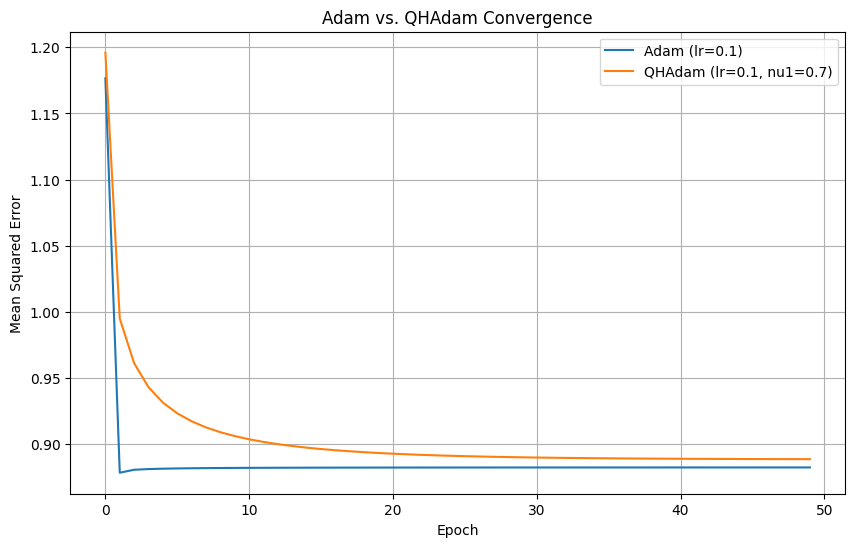

In [5]:
X = 2 * np.random.rand(100, 1)
y = 1 + 2 * X + np.random.randn(100, 1)

def train(optimizer, epochs=50):
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(len(X)):
            x_sample, y_sample = X[i:i+1], y[i:i+1]
            w, b = optimizer.params
            y_pred = linear_model(x_sample, w, b)
            epoch_loss += mse_loss(y_sample, y_pred)
            optimizer.zero_grad()
            compute_gradients(x_sample, y_sample, y_pred, w, b)
            optimizer.step()
        loss_history.append(epoch_loss / len(X))
    
    current_lr = getattr(optimizer, 'lr', 'N/A')
    print(f"Optimizer: {optimizer.__class__.__name__} (lr={current_lr})")
    w, b = optimizer.params
    print(f"Final Weights: w={w.data.item():.2f}, b={b.data.item():.2f}\n")
    return loss_history

# with Adam
np.random.seed(42)
w_adam = Parameter(np.random.randn(1, 1)); b_adam = Parameter(np.zeros(1))
adam_optimizer = Adam(params=[w_adam, b_adam], lr=0.1)
adam_losses = train(adam_optimizer)

# with QHAdam
np.random.seed(42)
w_qhadam = Parameter(np.random.randn(1, 1)); b_qhadam = Parameter(np.zeros(1))
qhadam_optimizer = QHAdam(params=[w_qhadam, b_qhadam], lr=0.1, nu1=0.7, nu2=1.0)
qhadam_losses = train(qhadam_optimizer)

plt.figure(figsize=(10, 6))
plt.plot(adam_losses, label='Adam (lr=0.1)')
plt.plot(qhadam_losses, label='QHAdam (lr=0.1, nu1=0.7)')
plt.title('Adam vs. QHAdam Convergence')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()